In [4]:
# import the necessary packages.
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#!pip install torchsummary
from torchsummary import summary


In [5]:
# Check for CUDA
use_cuda = torch.cuda.is_available()
print("cuda", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
print("device",device)

cuda True
device cuda


In [6]:
# importing the model from the model.py
from model import Net

In [7]:
# Calling the model
model = Net().to(device)
# displaying the model summary.
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
            Conv2d-3           [-1, 16, 14, 14]           2,320
       BatchNorm2d-4           [-1, 16, 14, 14]              32
         MaxPool2d-5             [-1, 16, 7, 7]               0
           Dropout-6             [-1, 16, 7, 7]               0
            Conv2d-7             [-1, 16, 5, 5]           2,320
       BatchNorm2d-8             [-1, 16, 5, 5]              32
            Conv2d-9             [-1, 32, 3, 3]           4,640
      BatchNorm2d-10             [-1, 32, 3, 3]              64
           Conv2d-11             [-1, 32, 3, 3]           9,248
      BatchNorm2d-12             [-1, 32, 3, 3]              64
        AvgPool2d-13             [-1, 32, 1, 1]               0
           Linear-14                   

In [8]:
# Train data transformations

torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


100%|██████████| 9912422/9912422 [00:00<00:00, 148014209.28it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 36095260.38it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43060690.60it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4913729.37it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



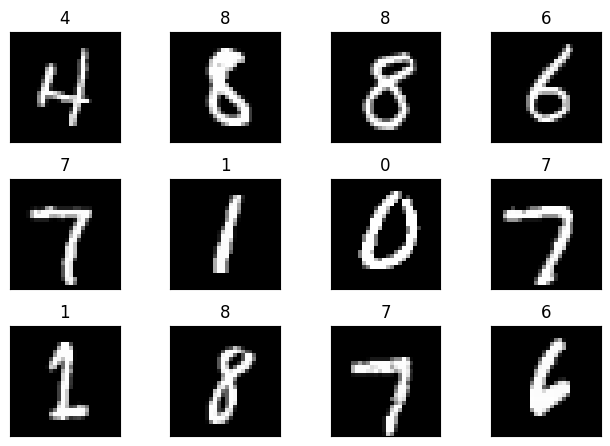

In [9]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [10]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [11]:
# Function fopr Training the model of the train dataset.
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        output = model(data)

        # Calculate loss
        loss = F.nll_loss(output, target)
        train_loss+=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(output, target)
        processed += len(data)
        #pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')


    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))

# Testing the trained model on test dataset to the check loss and model accuracy
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [12]:
# performance optimization of the model.
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    print(f'Epoch {epoch}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Epoch 1


Train: Loss=0.0747 Batch_id=468 Accuracy=93.13: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]



Test set: Average loss: 0.0565, Accuracy: 9857/10000 (98.57%)

Epoch 2


Train: Loss=0.0251 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:16<00:00, 28.51it/s]



Test set: Average loss: 0.0405, Accuracy: 9878/10000 (98.78%)

Epoch 3


Train: Loss=0.0247 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:16<00:00, 28.56it/s]



Test set: Average loss: 0.0334, Accuracy: 9890/10000 (98.90%)

Epoch 4


Train: Loss=0.0607 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:16<00:00, 27.84it/s]



Test set: Average loss: 0.0323, Accuracy: 9903/10000 (99.03%)

Epoch 5


Train: Loss=0.0186 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:17<00:00, 27.53it/s]



Test set: Average loss: 0.0303, Accuracy: 9902/10000 (99.02%)

Epoch 6


Train: Loss=0.0122 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 28.52it/s]



Test set: Average loss: 0.0263, Accuracy: 9915/10000 (99.15%)

Epoch 7


Train: Loss=0.0129 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:17<00:00, 27.20it/s]



Test set: Average loss: 0.0242, Accuracy: 9927/10000 (99.27%)

Epoch 8


Train: Loss=0.0051 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:16<00:00, 28.22it/s]



Test set: Average loss: 0.0284, Accuracy: 9922/10000 (99.22%)

Epoch 9


Train: Loss=0.0108 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:17<00:00, 26.93it/s]



Test set: Average loss: 0.0272, Accuracy: 9906/10000 (99.06%)

Epoch 10


Train: Loss=0.0106 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:17<00:00, 26.98it/s]



Test set: Average loss: 0.0243, Accuracy: 9918/10000 (99.18%)

Epoch 11


Train: Loss=0.0219 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:16<00:00, 28.11it/s]



Test set: Average loss: 0.0259, Accuracy: 9918/10000 (99.18%)

Epoch 12


Train: Loss=0.0126 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:17<00:00, 26.75it/s]



Test set: Average loss: 0.0239, Accuracy: 9921/10000 (99.21%)

Epoch 13


Train: Loss=0.0084 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:16<00:00, 28.29it/s]



Test set: Average loss: 0.0255, Accuracy: 9926/10000 (99.26%)

Epoch 14


Train: Loss=0.0009 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:16<00:00, 28.16it/s]



Test set: Average loss: 0.0268, Accuracy: 9915/10000 (99.15%)

Epoch 15


Train: Loss=0.0013 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:17<00:00, 26.37it/s]



Test set: Average loss: 0.0268, Accuracy: 9916/10000 (99.16%)

Epoch 16


Train: Loss=0.0405 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:16<00:00, 28.13it/s]



Test set: Average loss: 0.0235, Accuracy: 9936/10000 (99.36%)

Epoch 17


Train: Loss=0.0086 Batch_id=468 Accuracy=99.70: 100%|██████████| 469/469 [00:17<00:00, 27.51it/s]



Test set: Average loss: 0.0230, Accuracy: 9932/10000 (99.32%)

Epoch 18


Train: Loss=0.0033 Batch_id=468 Accuracy=99.71: 100%|██████████| 469/469 [00:16<00:00, 28.65it/s]



Test set: Average loss: 0.0265, Accuracy: 9922/10000 (99.22%)

Epoch 19


Train: Loss=0.0019 Batch_id=468 Accuracy=99.75: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]



Test set: Average loss: 0.0237, Accuracy: 9923/10000 (99.23%)



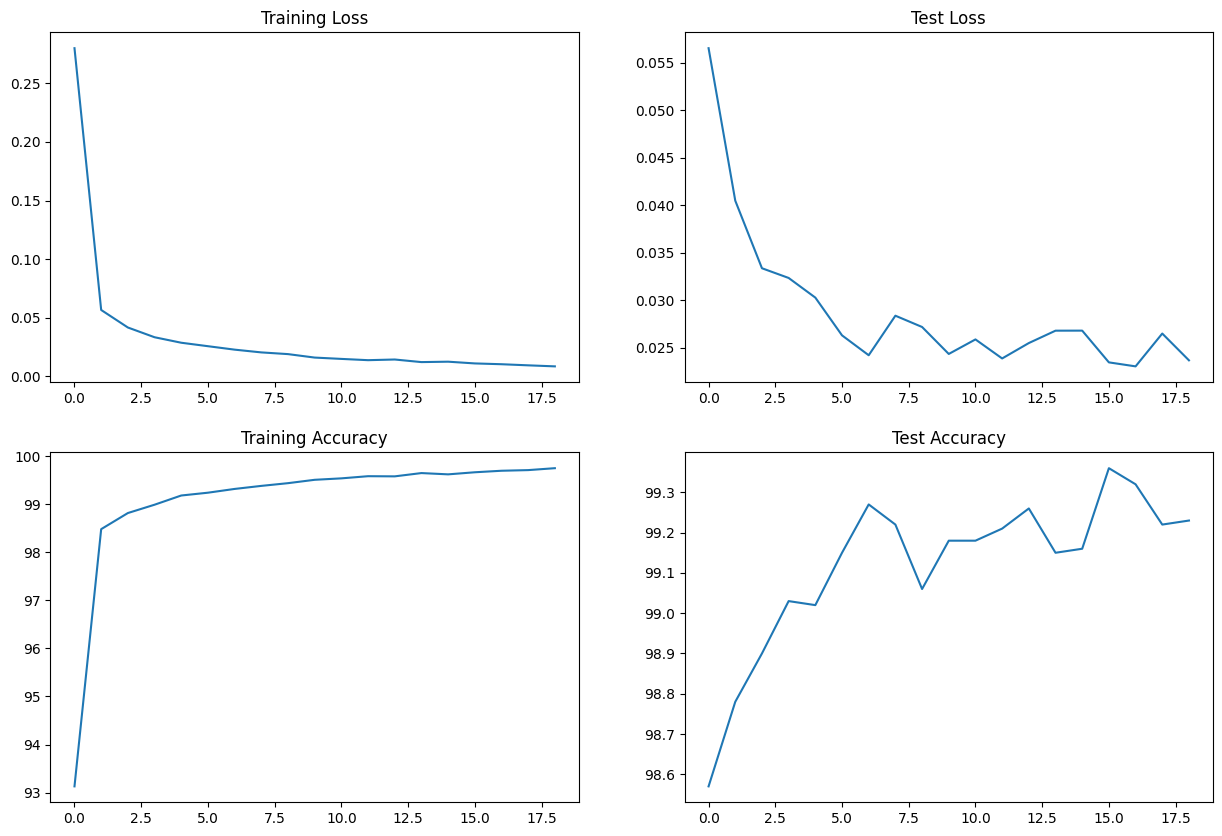

In [13]:
# Display the loss and accuracy in tranining and Test Data.
from utils import display_plot

display_plot(train_losses,train_acc,test_losses,test_acc)